In [1]:
from pathlib import Path
import os
import httpx
from hypha_rpc import connect_to_server, login


server_url="https://hypha.aicell.io"
workspace="chiron-platform"
token = os.environ["HYPHA_TOKEN"] or await login({"server_url": server_url})
server = await connect_to_server({"server_url": server_url, "token": token, "workspace": workspace})

artifact_manager = await server.get_service("public/artifact-manager")

dataset_manifest = {
    "name": "HPA Demo",
    "description": "An annotated dataset for Cellpose finetuning",
    "type": "data",
}
parent_id = "chiron-platform/collection"

# Check existing deployments
deployment_alias = dataset_manifest["name"].lower().replace(" ", "-")
all_artifacts = []
for artifact in await artifact_manager.list():
    if artifact.type == "collection":
        all_artifacts.extend(await artifact_manager.list(parent_id=artifact.id))
    else:
        all_artifacts.append(artifact)

exists = False
for artifact in all_artifacts:
    if artifact.alias == deployment_alias:
        exists = True
        break

if exists:
    # Edit the existing deployment and stage it for review
    artifact = await artifact_manager.edit(
        artifact_id=artifact.id,
        manifest=dataset_manifest,
        type=dataset_manifest.get("type"),
        version="stage",
    )
    print(f"Artifact edited with ID: {artifact.id}")
else:
    # Add the deployment to the gallery and stage it for review
    artifact = await artifact_manager.create(
        alias=deployment_alias,
        parent_id=parent_id,
        manifest=dataset_manifest,
        type=dataset_manifest.get("type"),
        version="stage",
    )
    print(f"Artifact created with ID: {artifact.id}")

# Load the dataset content
image_dir = Path.cwd().parent / "data" / "hpa_demo" / "data.zip"
dataset_content = image_dir.read_bytes()

# Upload manifest.yaml
upload_url = await artifact_manager.put_file(artifact.id, file_path="manifest.yaml")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(upload_url, data=dataset_manifest)
    response.raise_for_status()
    print(f"Uploaded manifest.yaml to artifact")

# Upload the entry point
upload_url = await artifact_manager.put_file(artifact.id, file_path="data.zip")
async with httpx.AsyncClient(timeout=30) as client:
    response = await client.put(upload_url, data=dataset_content)
    response.raise_for_status()
    print(f"Uploaded data.zip to artifact")

Artifact edited with ID: chiron-platform/hpa-demo
Uploaded manifest.yaml to artifact
Uploaded data.zip to artifact


In [2]:
import tempfile
import httpx
import zipfile
from pathlib import Path

# Create a temporary directory to save the downloaded file
data_dir = tempfile.mkdtemp()

# Define the path to save the downloaded zip file
zip_file_path = Path(data_dir) / "data.zip"

# Download the zip file
download_url = await artifact_manager.get_file(
    artifact_id="hpa-demo", file_path="data.zip"
)

async with httpx.AsyncClient(timeout=30) as client:
    response = await client.get(download_url)
    response.raise_for_status()
    with open(zip_file_path, "wb") as f:
        f.write(response.content)

# Unzip the downloaded file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(data_dir)

print(f"Data downloaded and extracted to: {data_dir}")

Data downloaded and extracted to: /tmp/tmpu4m637jn


In [5]:
data_dir

'/tmp/tmpu4m637jn'

In [ ]:
import tempfile
from pathlib import Path
import numpy as np
from cellpose import models, train, io, metrics


image_dir = Path(data_dir) / "hpa_demo"
annotations_dir = image_dir / "annotations"

# List to hold pairs of image and corresponding annotation masks
image_annotation_pairs = []

# Get list of all images and annotations
annotation_files = list(annotations_dir.glob("*.tif"))

# Iterate through each annotation file
for annotation_file in annotation_files:
    annotation_name = annotation_file.name
    image_name = annotation_name.split("_mask_")[0]
    image_file = image_dir / f"{image_name}.tif"

    image_annotation_pairs.append((image_file, annotation_file))


# Print the number of annotations
print(f"Number of annotations: {len(image_annotation_pairs)}")

Number of annotations: 6


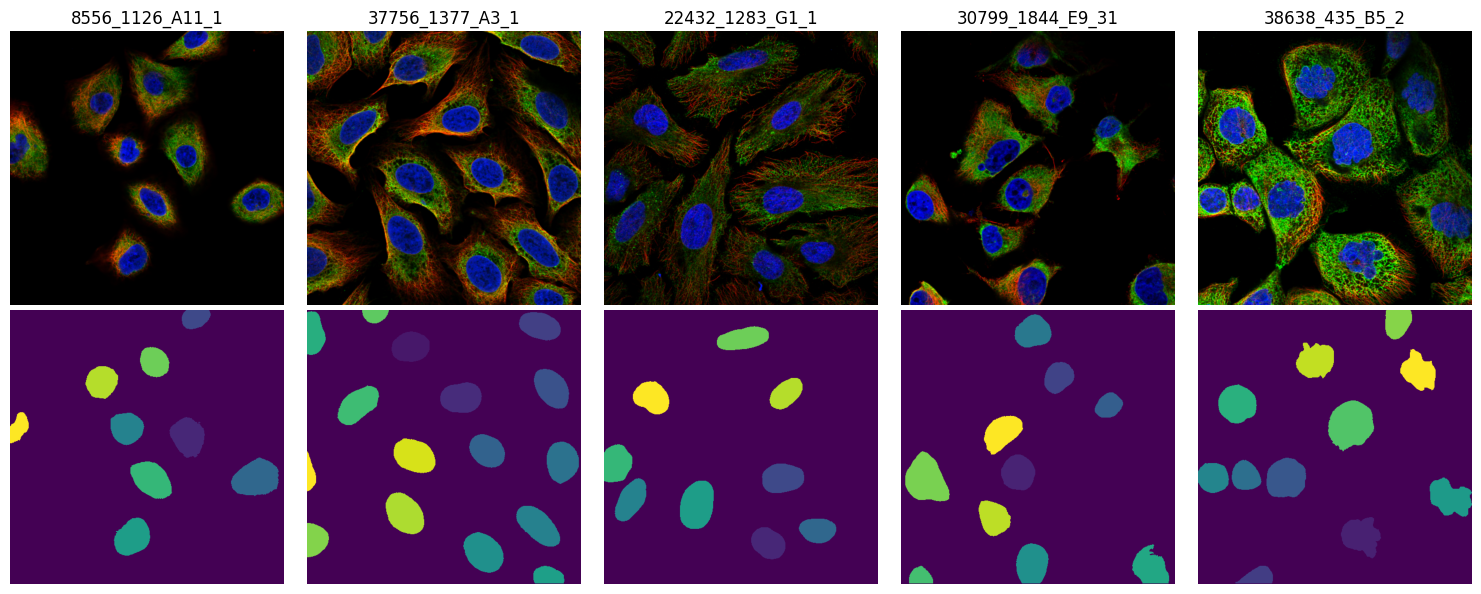

In [11]:
import matplotlib.pyplot as plt
from tifffile import imread


assert len(image_annotation_pairs) >= 5


# Plot several random annotations
choices = np.random.choice(len(image_annotation_pairs), 5, replace=False)
plt.figure(figsize=(15, 6))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    img = imread(image_annotation_pairs[choices[i]][0])
    plt.imshow(img.transpose(1, 2, 0))
    plt.title(f"{image_annotation_pairs[choices[i]][0].stem}")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    mask = imread(image_annotation_pairs[choices[i]][1])
    plt.imshow(mask)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Get all indices of the list
all_indices = np.arange(len(image_annotation_pairs))

# Define the split ratio (e.g., 80% train, 20% test)
train_ratio = 0.8
train_size = int(len(all_indices) * train_ratio)

# Randomly shuffle and split indices
np.random.shuffle(all_indices)
train_indices = all_indices[:train_size]
test_indices = all_indices[train_size:]

# Create train and test splits
train_files = [image_annotation_pairs[i][0] for i in train_indices]
train_labels_files = [image_annotation_pairs[i][1] for i in train_indices]
test_files = [image_annotation_pairs[i][0] for i in test_indices]
test_labels_files = [image_annotation_pairs[i][1] for i in test_indices]

In [13]:
initial_model = "cyto3"  # ["cyto", "cyto3", "nuclei", "tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "None"]
output_model_name = "CP_HPA"

channels_lut = {
    "Grayscale": 0,
    "Red": 1,
    "Green": 2,
    "Blue": 3,
}

channels = [
    channels_lut["Grayscale"],  # Channel to use for training
    channels_lut["Grayscale"],  # Second training channel (if applicable)
]

n_epochs =  10
learning_rate = 0.000001
weight_decay = 0.0001

save_path = tempfile.mkdtemp()

In [14]:
# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=True, model_type=initial_model)

new_model_path = train.train_seg(
    model.net,
    train_files=train_files,
    train_labels_files=train_labels_files,
    test_files=test_files,
    test_labels_files=test_labels_files,
    channels=channels,
    save_path=save_path,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    SGD=True,
    nimg_per_epoch=1,
    model_name=output_model_name,
    min_train_masks=1
)

100%|██████████| 2/2 [00:00<00:00, 570.54it/s]


In [26]:
new_model_path[0]

PosixPath('/tmp/tmpef10d5i9/models/CP_HPA')

In [15]:
# get files (during training, test_data is transformed so we will load it again)
test_data = [imread(image_path) for image_path in test_files[:2]]
test_labels = [imread(image_path) for image_path in test_labels_files[:2]]

# diameter of labels in training images
# use model diameter if user diameter is 0
diameter=0
diameter = model.diam_labels if diameter==0 else diameter
diam_labels = model.diam_labels.item()

# run model on test images
masks = model.eval(
    test_data,
    channels=channels,
    diameter=diam_labels
)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


>>> average precision at iou threshold 0.5 = 0.387


In [23]:
ap = metrics.average_precision(test_labels, masks, threshold=[0.5, 0.75, 0.9])[0]

In [24]:
{t: p for t, p in zip([0.5, 0.75, 0.9], ap.mean(axis=0))}

{0.5: np.float32(0.38704318),
 0.75: np.float32(0.2025),
 0.9: np.float32(0.024590164)}

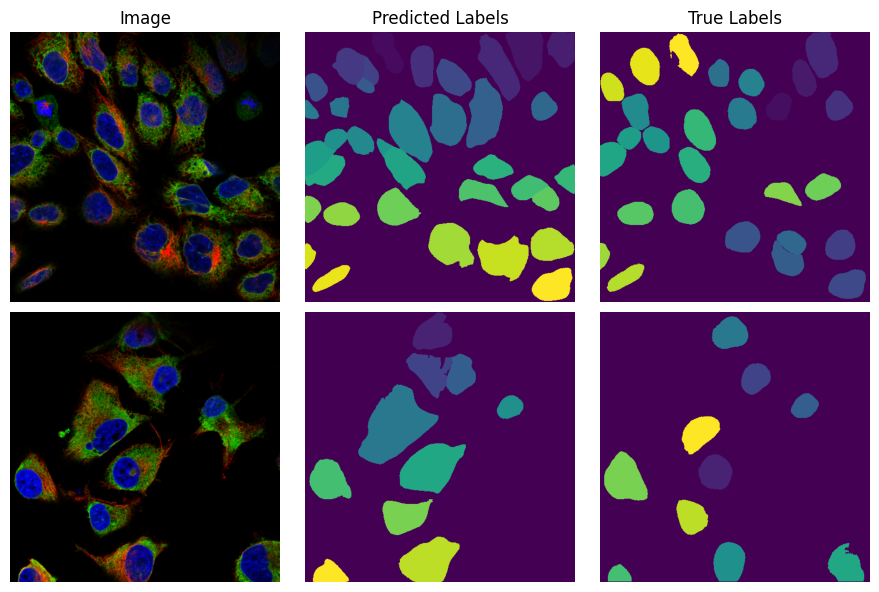

In [26]:
plt.figure(figsize=(9, 6))

for i in range(2):  # Two rows
    # Plot the image
    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(test_data[i].transpose(1, 2, 0))
    plt.axis('off')
    if i == 0:
        plt.title('Image')

    # Plot the predicted labels
    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(masks[i])
    plt.axis('off')
    if i == 0:
        plt.title('Predicted Labels')

    # Plot the true labels
    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(test_labels[i])
    plt.axis('off')
    if i == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()

In [ ]:
import os

os.remove(save_path)